In [66]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import math
import tiktoken
import torch
import torch.nn as nn

In [67]:
# 0，设置超参数Setup Hyperparameters
batch_size = 4  # 每个 batch 中包含的数据样本数量
context_length = 16  # Length of the token chunk each batch
d_model = 64  # The vector size of the token embeddings
num_layers = 8  # Number of transformer blocks
num_heads = 4  # Number of heads in Multi-head attention # 我们的代码中通过 d_model / num_heads = 来获取 head_size
learning_rate = 1e-3  # 学习率
dropout = 0.1 # Dropout rate
max_iters = 500  # Total of training iterations # 控制训练循环的终止条件 #在实际训练中，除了使用 max_iters 作为硬终止条件外，还可能结合早停法（Early Stopping）等技术。早停法会在验证集上的性能不再提升时提前终止训练，而 max_iters 可以作为一个兜底的终止条件，防止训练过程无限期地进行下去
eval_interval = 50  # How often to evaluate the model # 当训练迭代次数达到 eval_interval 的整数倍时，会暂停训练，使用验证集数据对模型进行评估，计算相关评估指标，以监控模型的性能
eval_iters = 20  # How many iterations to average the loss over when evaluating the model # 在每次评估模型时，并不是只计算当前迭代的损失值，而是计算最近 eval_iters 次迭代的损失值的平均值，以此来更稳定、准确地反映模型在一段时间内的性能表现。例如，当 eval_interval 为 50 时，在第 50 次迭代进行模型评估，此时会计算从第 31 次（50 - 20 + 1）迭代到第 50 次迭代这 20 次的损失平均值作为本次评估的损失指标
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Instead of using the cpu, we'll use the GPU if it's available.

TORCH_SEED = 1337 # 设置随机数种子，随机数种子用于初始化随机数生成器，以便在不同的运行中能够得到相同的随机数序列
torch.manual_seed(TORCH_SEED) # 通过设置固定的随机数种子，可以确保在多次运行代码时，随机数生成的结果是相同的

In [68]:
# 1，输入准备阶段：准备数据集Prepare the Dataset 
# # download a sample txt file from https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt
if not os.path.exists('../data/sales_textbook.txt'):
    url = 'https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt'
    with open('sales_textbook.txt', 'w') as f:
        f.write(requests.get(url).text)

with open('../data/sales_textbook.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    

In [69]:
# 2，输入准备阶段：分词化Tokenization
# Using TikToken to tokenize the source text
# 使用 tiktoken 库对数据集进行标记化。该库是一种快速且轻量级的分词器，可用于将文本分词化为分词
encoding = tiktoken.get_encoding("cl100k_base") #tiktoken 是 OpenAI 开发的一个用于处理文本和标记（token）之间转换的库，它可以将文本编码为模型能够处理的标记序列，也可以将标记序列解码回原始文本
encoding_text = encoding.encode(text)

# Illustration purpose
print(encoding.encode('Chapter 1: Building Rapport and Capturing'))
print(encoding.decode([26072, 220, 16, 25, 17283, 23097, 403, 323, 17013, 1711])) # "Rapport" is tokenized as two tokens: "Rap"[23097] and "port"[403]

print(f"the first 10 tokens of encoding text: {encoding_text[:10]}")

tokenized_text = torch.tensor(encoding_text, dtype=torch.long, device=device) # Convert tokens into a tensor
max_token_value = tokenized_text.max().item() # the maximum index value in our vocabulary
print(f"the first 10 items in the tensor tokenized_text: {tokenized_text[:10]}")

print(f"Tokenized text size: {len(tokenized_text)}")
print(f"The maximum value in the tensor tokenized_text is: {max_token_value}")

[26072, 220, 16, 25, 17283, 23097, 403, 323, 17013, 1711]
Chapter 1: Building Rapport and Capturing
the first 10 tokens of encoding text: [26072, 220, 16, 25, 17283, 23097, 403, 323, 17013, 1711]
the first 10 items in the tensor tokenized_text: tensor([26072,   220,    16,    25, 17283, 23097,   403,   323, 17013,  1711])
Tokenized text size: 77919
The maximum value in the tensor tokenized_text is: 100069


In [70]:
# 3，输入准备阶段：分割训练集和验证集Split train and validation
# 将数据集拆分为训练集和验证集。训练集将用于训练模型，验证集将用于评估模型的性能。
split_idx = int(len(tokenized_text) * 0.9)
train_data = tokenized_text[:split_idx]
val_data = tokenized_text[split_idx:]

In [71]:
# 4，输入准备阶段：准备训练数据Prepare data for training batch
# 用于训练和损失计算，训练集将用于训练模型，验证集将用于评估模型的性能
# x_batch 和 y_batch 用于准备模型训练所需的数据批次，其中 y_batch 主要用于模型训练时计算损失，x_batch 主要用于模型训练时计算梯度。
data = train_data
idxs = torch.randint(low=0, high=len(data) - context_length, size=(batch_size,)) # 生成一个包含 batch_size 个随机整数的一维张量 idxs，这些随机整数的范围在 0 到 len(data) - context_length - 1 之间。这些索引通常用于从数据集中随机采样出 batch_size 个样本，每个样本的长度为 context_length，以便用于模型的训练或其他操作。例如，假设 len(data) = 100，context_length = 10，batch_size = 8，那么 idxs 将会是一个包含 8 个在 0 到 89 之间（100 - 10 - 1 = 89）的随机整数的一维张量，如 tensor([12, 35, 6, 47, 23, 78, 19, 56])
print(f"all items in the tensor idxs: {idxs[:]}")

x_batch = torch.stack([data[idx:idx + context_length] for idx in idxs]) # 将 idxs 中的每个索引 idx 作为起点，从数据集中采样出长度为 context_length 的子序列，并将其堆叠成一个二维张量 x_batch。这个张量的大小为 [batch_size, context_length]，表示每个样本的上下文序列。例如，如果 idxs = tensor([12, 35, 6, 47])，那么 x_batch 将会是一个大小为 [4, 10] 的张量，表示每个样本的上下文序列长度为 10，且每个样本的上下文序列分别为 data[12:22], data[35:45], data[6:16], data[47:57]。
print(f"the first 10 items in the tensor x_batch: {x_batch[:10]}")

y_batch = torch.stack([data[idx + 1:idx + context_length + 1] for idx in idxs]) # 在语言模型等任务中，模型的目标是根据输入的一段文本预测下一个词。x_batch 作为模型的输入，包含了当前的文本序列；而 y_batch 包含了对应的下一个位置的文本序列，也就是模型需要预测的目标。在训练过程中，模型会根据 x_batch 做出预测，然后通过计算预测结果与 y_batch 之间的差异（如交叉熵损失）来调整模型的参数，使得模型的预测结果更接近真实的 y_batch。假设 data 是一个包含文本标记的列表，context_length 为 5，idxs 中有一个索引值 idx 为 10。那么 x_batch 对应的一段数据可能是 data[10:15]，而 y_batch 对应的则是 data[11:16] ，y_batch 中每个位置的元素就是模型在看到 x_batch 对应位置元素时应该预测的目标。

print(f"the first 10 items in the tensor y_batch: {y_batch[:10]}")

print(x_batch.shape, y_batch.shape)

all items in the tensor idxs: tensor([35754, 55550, 63572,  1447])
the first 10 items in the tensor x_batch: tensor([[  279,  6763,  1920,    13,   578,  5845,   311, 13750, 19570,   279,
           907,   323,  7720,   315,  1057,  3956],
        [ 3495, 14955,    11,   477,  5064, 23146,   430,  9788,   279, 66732,
           315,   701, 10209,    13,  3296, 32644],
        [38769, 10742,    11, 20958,   264,  6928, 19451,    11, 11125, 64784,
            11,   323, 56501, 54111,   439,  6975],
        [43496,   872,  8830,   719,  1101,  3727,   279,  6130,  2733,  6755,
           323, 16365,   627, 29831, 19682,  5900]])
the first 10 items in the tensor y_batch: tensor([[ 6763,  1920,    13,   578,  5845,   311, 13750, 19570,   279,   907,
           323,  7720,   315,  1057,  3956,   477],
        [14955,    11,   477,  5064, 23146,   430,  9788,   279, 66732,   315,
           701, 10209,    13,  3296, 32644,  1521],
        [10742,    11, 20958,   264,  6928, 19451,    11, 1112

In [72]:
# 5，输入准备阶段：将训练数据的张量表示转换为向量表示Convert the tensor representation of the training data into a vector representation
# 定义词嵌入查找表（Token Embedding Look-up Table）是 Transformer 模型中用于将输入文本中的标记（tokens）转换为向量表示的查找表。它将每个标记映射为一个固定大小的向量，这个向量可以作为模型的输入，用于计算注意力机制、前馈神经网络等操作。
# 通过将 x_batch 和 y_batch 作为索引输入到查找表中，可以得到对应的词嵌入向量。 在深度学习模型（如 Transformer）中，将张量变成向量进行计算主要有以下几个原因：
# 适应模型结构：Transformer 等模型中的后续层（如多头注意力机制、前馈神经网络等）通常期望输入具有特定的形状和维度。将输入数据转换为向量形式，能使数据的维度与模型各层的输入要求相匹配，便于模型进行有效的计算和特征提取。例如多头注意力机制中，需要对输入进行线性变换、维度拆分等操作，合适的向量表示能满足这些计算的需求。
# 编码语义信息：通过嵌入层（如这里的token_embedding_lookup_table）将标记（token）转换为向量，能够将离散的标记映射到连续的向量空间中。在这个向量空间里，语义相似的标记在距离上会更接近，从而使模型能够更好地捕捉和利用数据中的语义信息。比如在文本任务中，不同单词的嵌入向量可以反映它们之间的语义关联，这有助于模型理解文本的含义。
# 提高计算效率：向量形式的数据在现代硬件（如 GPU）上能更高效地进行并行计算。GPU 擅长处理大规模的矩阵运算，将张量转换为向量后，模型可以充分利用 GPU 的并行计算能力，加速模型的训练和推理过程，提升计算效率
token_embedding_lookup_table = nn.Embedding(max_token_value+1, d_model)
print("Token Embedding Look-up table: ", token_embedding_lookup_table)

x_batch_embedding = token_embedding_lookup_table(x_batch.data) # [4, 16, 64] [batch_size, context_length, d_model]
y_batch_embedding = token_embedding_lookup_table(y_batch.data)

print(x_batch_embedding.shape, y_batch_embedding.shape)
print(pd.DataFrame(x_batch_embedding[0].detach().cpu().numpy()))
print(pd.DataFrame(y_batch_embedding[0].detach().cpu().numpy()))


Token Embedding Look-up table:  Embedding(100070, 64)
torch.Size([4, 16, 64]) torch.Size([4, 16, 64])
          0         1         2         3         4         5         6         7         8         9   ...        54        55        56        57        58        59        60        61        62        63
0   1.399742 -1.206918  0.327990 -0.251130  0.531874 -0.248193  0.351937 -0.389238  0.129977 -1.207580  ... -0.547752  1.515671  1.223744  0.833670 -0.404194  0.563554  0.591292 -0.724745  1.670105 -0.241721
1   0.566486 -1.102276  1.712332 -0.354509  0.550577 -0.707943 -0.743899  0.757765  0.018193  1.392380  ...  0.873562  1.226714  0.794431  0.598629  0.884421  0.032520  1.353617  0.059697  1.172510  0.527427
2  -0.426478  1.717362 -0.343810 -0.917124 -0.273610  0.695366 -0.849842 -1.301135 -0.162554 -0.252811  ... -0.934960  1.145729 -1.914149 -0.447346  0.597272  1.673483 -1.969475  0.397835 -0.438475 -0.562923
3   0.709939  1.369311 -0.707588  1.538689 -2.110915  0.441344 -0.

In [73]:
# 6，输入准备阶段：应用位置嵌入Apply Positional Embedding
# 如最初的 “Attention is All You Need” 论文中所述，我们将使用 sine 和 cosine 生成位置嵌入表，然后将这些位置信息添加到输入嵌入标记中。
# 总结位置编码解决的问题：我们希望每个单词都带有一些关于它在句子中的位置的信息。我们希望模型将看起来彼此靠近的单词视为 “close”，将距离较远的单词视为 “distant”。我们希望位置编码表示模型可以学习的模式。
# 这个位置编码矩阵只创建一次，并为每个输入序列重复使用。
# Define Position Encoding look-up table
position_encoding_lookup_table = torch.zeros(context_length, d_model)
position = torch.arange(0, context_length, dtype=torch.float).unsqueeze(1)
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
position_encoding_lookup_table[:, 0::2] = torch.sin(position * div_term)
position_encoding_lookup_table[:, 1::2] = torch.cos(position * div_term)
position_encoding_lookup_table = position_encoding_lookup_table.unsqueeze(0).expand(batch_size, -1, -1) #add batch dimension

print("Position Encoding Look-up Table: ", position_encoding_lookup_table.shape) # [4, 16, 64] [batch_size, context_length, d_model]
print(pd.DataFrame(position_encoding_lookup_table[0].detach().cpu().numpy()))

Position Encoding Look-up Table:  torch.Size([4, 16, 64])
          0         1         2         3         4         5         6         7         8         9   ...        54        55        56        57        58        59        60        61        62        63
0   0.000000  1.000000  0.000000  1.000000  0.000000  1.000000  0.000000  1.000000  0.000000  1.000000  ...  0.000000  1.000000  0.000000  1.000000  0.000000  1.000000  0.000000  1.000000  0.000000  1.000000
1   0.841471  0.540302  0.681561  0.731761  0.533168  0.846009  0.409309  0.912396  0.310984  0.950415  ...  0.000422  1.000000  0.000316  1.000000  0.000237  1.000000  0.000178  1.000000  0.000133  1.000000
2   0.909297 -0.416147  0.997480  0.070948  0.902131  0.431463  0.746903  0.664932  0.591127  0.806578  ...  0.000843  1.000000  0.000632  1.000000  0.000474  1.000000  0.000356  1.000000  0.000267  1.000000
3   0.141120 -0.989992  0.778273 -0.627927  0.993253 -0.115966  0.953635  0.300967  0.812649  0.582754  ...  0

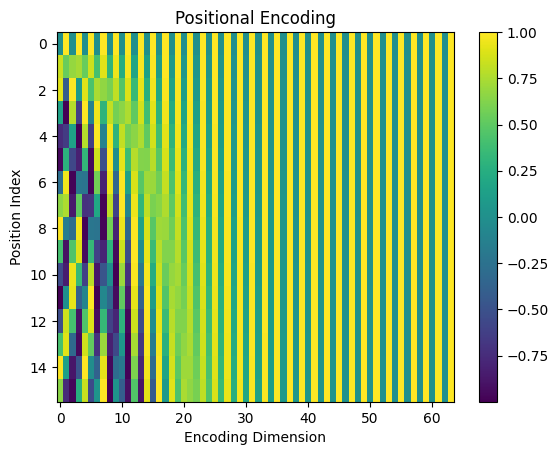

In [74]:
# Illustration Purpose Only
# 可视化我们的位置嵌入数字并查看模式
# 每条垂直线是 0 到 64 之间的维度;每行代表一个字符。这些值介于 -1 和 1 之间，因为它们来自正弦和余弦函数。颜色较暗表示值更接近 -1，颜色较亮表示值更接近 1。绿色表示介于两者之间的值
def visualize_pe(pe):
    plt.imshow(pe, aspect="auto")
    plt.title("Positional Encoding")
    plt.xlabel("Encoding Dimension")
    plt.ylabel("Position Index")
    plt.colorbar()
    plt.show()

position_encoding_lookup_table2_np = position_encoding_lookup_table[0].cpu().numpy()
visualize_pe(position_encoding_lookup_table2_np)

In [75]:
# 7，输入准备阶段：将位置信息添加到每个输入嵌入行中，以获得最终输入嵌入矩阵
# 由于两个形状相同的矩阵可以相加，因此我们可以将位置信息添加到每个输入嵌入行中，以获得最终输入嵌入矩阵
# Add positional encoding into the input embedding vector
input_embedding_x = x_batch_embedding + position_encoding_lookup_table # [4, 16, 64] [batch_size, context_length, d_model]
input_embedding_y = y_batch_embedding + position_encoding_lookup_table

print(pd.DataFrame(input_embedding_x[0].detach().cpu().numpy()))
print(pd.DataFrame(input_embedding_y[0].detach().cpu().numpy()))

          0         1         2         3         4         5         6         7         8         9   ...        54        55        56        57        58        59        60        61        62        63
0   1.399742 -0.206918  0.327990  0.748870  0.531874  0.751807  0.351937  0.610762  0.129977 -0.207580  ... -0.547752  2.515671  1.223744  1.833670 -0.404194  1.563555  0.591292  0.275255  1.670105  0.758279
1   1.407957 -0.561973  2.393893  0.377252  1.083745  0.138066 -0.334590  1.670161  0.329176  2.342795  ...  0.873984  2.226714  0.794747  1.598629  0.884658  1.032520  1.353795  1.059697  1.172643  1.527427
2   0.482819  1.301215  0.653670 -0.846175  0.628521  1.126829 -0.102938 -0.636202  0.428573  0.553768  ... -0.934116  2.145729 -1.913517  0.552654  0.597746  2.673483 -1.969119  1.397835 -0.438208  0.437077
3   0.851059  0.379319  0.070685  0.910763 -1.117662  0.325378  0.947827  0.472564  0.516017  0.790074  ...  0.072798  0.264451  0.070916 -1.744750  1.088080  0.002188 

In [76]:
# 8，特征提取与融合阶段-多头注意力机制：准备 Q、K、V 
# Prepare Query, Key, Value for Multi-head Attention
# 转换为 Q、K、V 的原因：
# 引入不同的表示视角：将输入X通过不同的线性变换得到Q、K、V，可以让模型从不同的角度对输入信息进行编码和处理。Q主要用于引导模型对信息的查询和关注，K用于提供信息的索引和标识，V则携带了实际的信息内容。这样的设计使得模型能够更灵活地捕捉输入数据中的复杂关系。
# 实现注意力机制：Q、K、V是注意力机制的核心组成部分。注意力机制的目的是让模型能够根据不同的任务需求，动态地关注输入序列中的不同部分。通过将输入转换为Q、K、V，模型可以计算出每个位置对于其他位置的注意力权重，从而有针对性地聚合信息，提高模型对重要信息的捕捉能力。
# 提高模型的灵活性和泛化能力：将输入转换为Q、K、V并进行注意力计算，使得模型能够自适应地关注输入数据中的不同部分，根据具体的任务和输入内容动态地调整注意力分布。这种灵活性使得模型能够更好地适应各种不同的语言现象和任务需求，提高了模型的泛化能力，能够在多种自然语言处理任务中取得较好的效果，如文本生成、机器翻译、问答系统等。
# 虽然模型在一定程度上可以解决输入序列中位置之间的相似度问题，但这只是其功能的一部分，更重要的是通过一系列的设计和计算，实现对输入数据的深度理解、信息融合和高效处理，以解决各种复杂的自然语言处理任务和其他相关领域的问题。
# 在 PyTorch 中，view 方法是用于改变张量形状的函数。它可以在不改变张量数据的情况下，将张量重新排列成指定的形状。其语法为 tensor.view(*shape)，其中 *shape 是一个可变参数，表示新的形状。
# 例如，如果有一个形状为 [4, 16, 64] 的张量，想要将其重塑为 [4, 16, 4, 16] 的形状，可以使用 view 方法，如下所示：
# tensor = torch.randn(4, 16, 64)
# reshaped_tensor = tensor.view(4, 16, 4, 16)
# 通过 view 函数对张量 Q、K、V 的形状进行了重新组织，以适应后续的计算需求，特别是在多头注意力机制的计算过程中。
X = input_embedding_x
query = key = value = X # [4, 16, 64] [batch_size, context_length, d_model]

print(query.shape)

Wq = nn.Linear(d_model, d_model) # nn.Linear：这是 PyTorch 中 torch.nn 模块里用于创建线性层（也称为全连接层）的类。线性层的作用是对输入数据进行线性变换，其数学公式为 y = x * W + b，其中 x 是输入张量，W 是权重矩阵，b 是偏置向量，y 是输出张量。有两个 d_model 参数。第一个 d_model 表示输入特征的维度，意味着这个线性层期望输入的张量在最后一个维度上有 d_model 个特征。第二个 d_model 表示输出特征的维度，即经过这个线性层变换后，输出张量在最后一个维度上也会有 d_model 个特征。例如，如果 d_model 的值为 64，那么这个线性层的输入和输出特征维度都是 64。
Wk = nn.Linear(d_model, d_model) # Wk 是一个自定义的变量名，用于存储创建的线性层对象。后续在模型的计算过程中，可以通过调用 Wk（例如 output = Wk(input)）来对输入数据应用这个线性变换。
Wv = nn.Linear(d_model, d_model)

Q = Wq(query) #[4, 16, 64]
Q = Q.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

K = Wk(key) #[4, 16, 64]
K = K.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

V = Wv(value) #[4, 16, 64]
V = V.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

# print(torch.round(Q[0] * 100) / 100)
qqq = Q.detach().cpu().numpy()
for qs in qqq:
    for qss in qs:
        print(pd.DataFrame(qss))

print(Q.shape) # [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]

torch.Size([4, 16, 64])
         0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0  0.843055 -0.550051 -0.127732 -0.844840 -0.819224  0.063522 -0.187879  1.182711 -1.542636  0.582238  0.123997 -0.023149  0.141312  0.812356 -1.628145  0.312126
1 -0.350486  0.484634 -0.140094  0.746821  1.481563 -0.266804  0.312059 -0.710153 -0.557109  0.462987 -0.575465  0.824084 -0.910005 -0.060633 -0.851141 -0.696344
2 -0.140998 -0.055692 -0.718412 -0.797249  0.366570  1.513673  0.577341 -0.707247 -0.275017  1.270264 -0.846118 -1.158900  1.652279  0.261800 -0.884520 -0.846511
3 -0.244500  0.759894  0.067822  0.388658 -0.178537  1.044808 -0.276759 -0.887757 -0.158977 -0.619547 -0.298364 -0.604880 -1.250719  0.388842 -1.088378  0.081781
         0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0  0

In [77]:
# 9，特征提取与融合阶段-多头注意力机制：重塑 Q、K、V 
# 将 Q、K、V 重塑为 [batch_size、num_heads、context_length、head_size] 以进行进一步计算
# 并行计算与高效性：模型的设计还考虑了计算效率。通过将Q、K、V表示为矩阵，并利用矩阵乘法等操作，可以在 GPU 等并行计算设备上进行高效的并行计算。这使得模型能够快速处理大规模的数据，大大提高了训练和推理的速度，使得在实际应用中处理大量文本数据成为可能。
# Transpose q,k,v from [batch_size, context_length, num_heads, head_size] to [batch_size, num_heads, context_length, head_size]
# The reason is that treat each batch with "num_heads" as its first dimension.
Q = Q.transpose(1, 2) # [4, 4, 16, 16]
K = K.transpose(1, 2) # [4, 4, 16, 16]
V = V.transpose(1, 2) # [4, 4, 16, 16]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.827912,0.872087,0.805252,0.638937,0.403635,-0.220579,0.074281,0.066307,0.161097,0.776864,-0.015753,0.059171,-0.167397,-0.519080,-0.113654,0.370162
1,1.123528,0.464093,0.514921,-0.184883,0.292599,-0.127226,0.205937,0.207778,0.602376,1.016719,0.158707,0.074483,0.526718,0.460966,0.633765,0.534267
2,1.040624,0.605709,0.119166,-0.133348,-0.169015,-0.146091,0.444743,0.050206,0.774002,0.830742,-0.216136,-0.111672,0.751038,0.496729,0.747770,0.609336
3,0.900045,0.596818,0.359724,0.836026,0.074438,0.652813,1.057635,-0.026944,1.124048,0.971823,-0.467323,-0.247706,0.002623,-0.360194,0.017813,0.965252
4,1.061119,1.158660,0.633724,-0.320907,0.383561,-0.448183,-0.238576,-0.078154,-0.033891,0.852194,0.056048,0.533376,0.968321,0.675573,0.506570,0.651593
5,0.071059,0.273445,0.044782,0.250272,-0.114290,0.121239,0.472959,0.086112,-0.077087,-0.158122,-0.416886,0.212225,0.220158,-0.492304,0.175022,0.505993
6,0.897961,1.322749,0.553525,0.079147,0.502846,-0.506932,0.223247,-0.400829,0.203914,0.658943,-0.018270,0.620022,0.600703,0.066074,0.316328,0.332746
7,0.025299,0.779429,0.627483,-0.354743,0.218848,-0.055096,0.297431,-0.119230,-0.025749,0.031660,0.079259,0.274235,0.095197,-0.625557,-0.000797,0.226548
8,0.529123,-0.196815,0.232964,0.031045,0.214278,-0.328799,-0.685732,0.060671,0.237945,0.642808,0.532076,0.191681,-0.066689,0.383821,-0.080174,0.330104
9,0.935247,0.690427,0.511019,1.063499,0.504674,-0.227777,-0.035515,-0.006277,0.174739,0.899135,0.184269,0.238904,-0.084467,-0.414827,-0.173580,0.431657


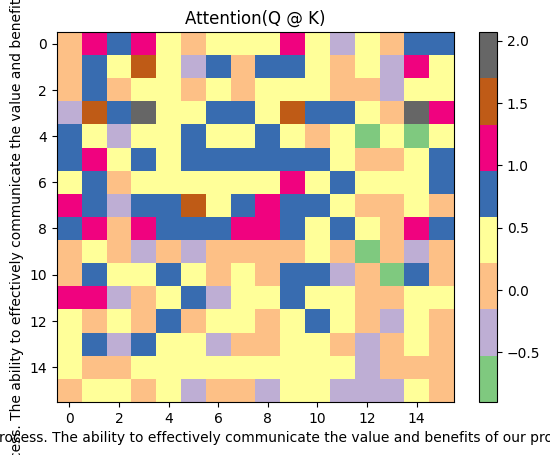

In [78]:
# 10，特征提取与融合阶段-多头注意力机制：计算注意力分数和缩放
# Calculate the attention score and scale
# Q 和 K 进行乘法的原因：
# 计算注意力得分：如前面所说，Q和K的乘法是为了计算注意力得分。具体来说，Q和K转置相乘的结果表示了Q中每个元素与K中每个元素之间的相似度或关联程度。在计算过程中，Q和K的维度通常是匹配的，这样矩阵乘法可以有效地在所有元素之间进行成对的计算，得到一个注意力得分矩阵。这个矩阵中的每个元素反映了相应Q和K元素之间的相关性，为后续确定注意力权重提供了基础。
# 捕捉长序列依赖关系：Transformer 等大模型设计的一个重要目标是解决长序列数据中的依赖关系问题。在自然语言处理等任务中，一个句子或文档中的不同位置之间可能存在长期的语义依赖关系。通过注意力机制，模型可以直接计算序列中任意两个位置之间的关联，而不受序列长度的限制，从而有效地捕捉长序列中的依赖关系，提高对文本等长序列数据的理解和处理能力。
# 信息筛选与融合：通过Q和K的乘法，模型可以根据计算出的注意力得分来筛选和融合V中的信息。高得分表示对应的Q和K元素之间具有较强的关联，因此在聚合V的信息时，与这些高得分相关的V元素会被赋予更高的权重，从而实现对重要信息的筛选和融合，使得模型能够生成更准确、更有针对性的输出。
attention_score = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_model // num_heads) # [4, 4, 16, 16] # Scale

# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q @ K)") #plot attention in the first head of the first batch
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.827912,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
1,1.123528,0.464093,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
2,1.040624,0.605709,0.119166,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
3,0.900045,0.596818,0.359724,0.836026,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
4,1.061119,1.158660,0.633724,-0.320907,0.383561,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
5,0.071059,0.273445,0.044782,0.250272,-0.114290,0.121239,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
6,0.897961,1.322749,0.553525,0.079147,0.502846,-0.506932,0.223247,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
7,0.025299,0.779429,0.627483,-0.354743,0.218848,-0.055096,0.297431,-0.119230,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
8,0.529123,-0.196815,0.232964,0.031045,0.214278,-0.328799,-0.685732,0.060671,0.237945,-inf,-inf,-inf,-inf,-inf,-inf,-inf
9,0.935247,0.690427,0.511019,1.063499,0.504674,-0.227777,-0.035515,-0.006277,0.174739,0.899135,-inf,-inf,-inf,-inf,-inf,-inf


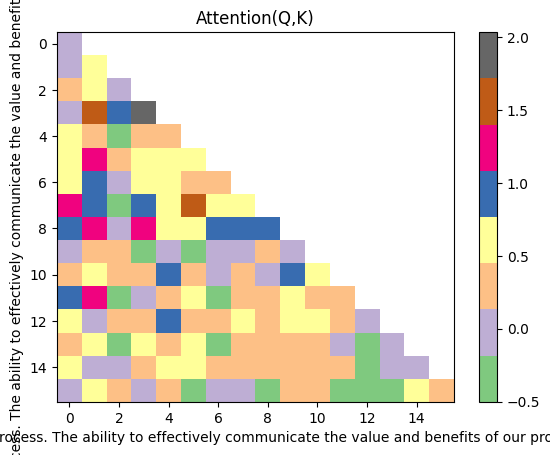

In [79]:
# 11，特征提取与融合阶段-多头注意力机制：掩码 Mask
# Apply Mask to attention scores
# 防止信息泄露（用于自注意力且输入为序列时）：在处理序列数据（如自然语言文本）的自注意力机制中，我们通常不希望一个位置的信息在计算时依赖于它后面位置的信息。例如在文本生成任务中，在生成第 i 个词时，模型只能基于前面 i-1 个词的信息，而不能提前看到后面的词。通过掩码操作可以实现这一点。
attention_score = attention_score.masked_fill(torch.triu(torch.ones(attention_score.shape[-2:]), diagonal=1).bool(), float('-inf'))#[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]

# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q,K)")
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

In [80]:
# 12，特征提取与融合阶段-多头注意力机制：指数归一化 Softmax
# Softmax the attention score
# 将得分转换为概率分布：softmax 函数可以将原始的注意力得分转换为一个概率分布，使得每个位置的注意力权重都在 0 到 1 之间，且所有位置的注意力权重之和为 1。这样就可以明确地表示每个位置在当前注意力计算中的相对重要性。例如，在处理文本时，经过 softmax 后，每个词对应的注意力权重表示了该词在当前语境下对于生成特定输出（如生成下一个词或理解句子语义）的重要程度比例。
# 便于模型学习和优化：将注意力得分转换为概率分布后，更符合模型的学习和优化过程。模型可以通过调整参数来最小化损失函数，而基于概率分布的表示使得模型能够更有效地学习到不同位置的重要性，从而更好地适应各种任务和输入数据。
# 突出重要信息：softmax 函数具有指数运算的特性，会将较大的得分放大，较小的得分缩小。这意味着在原始的注意力得分中，相对较大的得分经过 softmax 后会变得更加突出，对应的位置会获得更高的注意力权重，从而使模型能够更关注输入中的重要信息。例如，在处理图像时，对于包含物体关键特征的区域，其对应的注意力得分经过 softmax 后会得到较高的权重，模型就能更聚焦于这些区域进行特征提取和识别。
attention_score = torch.softmax(attention_score, dim=-1) #[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.659133,0.340867,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.488936,0.316498,0.194566,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.306845,0.226584,0.178756,0.287816,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.284609,0.313769,0.185624,0.071457,0.144541,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.159313,0.195051,0.155182,0.190583,0.132360,0.167512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.195804,0.299437,0.138751,0.086341,0.131894,0.048049,0.099724,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.100501,0.213640,0.183524,0.068726,0.121962,0.092737,0.131933,0.086976,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.176701,0.085500,0.131407,0.107381,0.128974,0.074929,0.052437,0.110609,0.132063,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.148425,0.116194,0.097110,0.168735,0.096496,0.046389,0.056222,0.057891,0.069378,0.143160,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [81]:
# 13，特征提取与融合阶段-多头注意力机制：计算 V 注意力
# Calculate the V attention output
# 结合注意力权重与值信息：通过前面的 q*k 计算得到的是注意力得分，经过 softmax 后得到的是归一化的注意力权重，它表示了输入序列中各个位置对于当前计算的重要性程度。而 V 代表了输入数据的特征表示（值向量）。将注意力权重与 V 相乘，能够根据每个位置的重要性程度对其对应的特征进行加权求和，从而得到综合考虑了注意力分布的输出表示。这样可以使模型在生成输出时，更加关注重要位置的特征信息，有效地融合了注意力机制和原始特征信息。
# 实现信息的选择性聚合：不同的位置可能对生成输出具有不同的贡献，通过注意力权重与 V 的相乘，模型能够有选择地聚合来自不同位置的信息。那些具有较高注意力权重的位置对应的 V 中的特征会被更多地保留和传递到输出中，而注意力权重较低的位置对应的特征则会被相对弱化。这种选择性聚合能够帮助模型更好地捕捉输入数据中的关键信息，过滤掉不重要的信息，从而提高模型的性能和泛化能力。
# 生成上下文相关的表示：在自然语言处理等任务中，例如文本生成或机器翻译，每个位置的输出都应该依赖于整个输入序列的上下文信息。通过将注意力权重与 V 相乘，可以根据当前位置与其他位置的注意力关系，动态地生成与上下文相关的表示。这样模型能够更好地理解文本中的语义关系，生成更符合上下文逻辑的输出。例如，在生成一个句子中的某个单词时，模型会根据该单词与句子中其他单词的注意力权重，结合其他单词的特征信息来生成更准确的表示，从而提高生成文本的质量。
print(attention_score.shape) #[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]
print(V.shape) #[4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]
A = torch.matmul(attention_score, V) # [4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]
print(A.shape)

torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])


In [82]:
# 14，特征提取与融合阶段-多头注意力机制：连接多头的注意力
# Concatenate the multi-head attention output
# 多头注意力机制中，将每个头的输出结果进行连接，会把输入分别通过不同的线性层得到多个头的查询（Q）、键（K）、值（V），然后分别计算每个头的注意力输出。在经过注意力计算、加权求和等操作得到每个头的输出结果后，就会进行 “Concatenate” 操作。
# 假设我们有 num_heads 个注意力头，每个头输出的张量形状为 [batch_size, sequence_length, head_dim]（batch_size 是批次大小，sequence_length 是序列长度，head_dim 是每个头的维度）。在连接这些头的输出时，是沿着最后一个维度（即 head_dim 所在维度）进行拼接。拼接后得到的张量形状变为 [batch_size, sequence_length, num_heads * head_dim] 。
A = A.transpose(1, 2) # [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]
A = A.reshape(batch_size, -1, d_model) # [4, 16, 64] [batch_size, context_length, d_model]
A.shape

torch.Size([4, 16, 64])

In [83]:
# 15，特征提取与融合阶段-多头注意力机制：定义多头注意力的最终输出（定义输出权重矩阵）
# Define the output weight matrix
# 在计算注意力机制的输出时乘以 Wo（一个线性变换矩阵）而不是直接使用 A（注意力机制的中间输出）用于后续计算，主要有以下几个原因：
# 特征变换与融合：
# A 的输出是经过注意力计算后得到的结果，但它可能还没有被映射到适合后续任务或模型结构的特征空间中。通过乘以 Wo，可以对 A 进行线性变换，将其特征映射到更有利于后续计算和模型学习的空间中。
# 这种线性变换可以融合不同维度的信息。d_model 通常是模型的隐藏层维度，在注意力机制中，不同位置和不同头的信息可能具有不同的特征表示。Wo 可以将这些信息进行加权组合和变换，使得输出能够更好地捕捉到各种语义和句法关系，为后续的任务（如文本生成、分类等）提供更有价值的特征。
# 模型灵活性与拟合能力：
# 引入 Wo 增加了模型的参数数量和灵活性。模型可以通过调整 Wo 的参数来更好地适应不同的任务和数据特点，提高模型的拟合能力。
# 不同的任务可能需要不同的特征表示和变换方式。Wo 可以学习到特定任务所需的特征映射，使得模型能够更准确地完成各种自然语言处理任务，如在情感分类任务中，Wo 可以将注意力输出变换为能够准确反映情感倾向的特征表示。
# 与模型其他部分的兼容性：
# 模型的后续部分可能对输入有特定的要求，例如特定的维度、数据分布等。乘以 Wo 可以将注意力输出调整为与后续层兼容的形式，确保模型能够顺利进行前向传播和反向传播。
# 在 Transformer 等模型架构中，通常会有多个不同的模块和层，Wo 有助于将注意力机制的输出与其他模块（如前馈神经网络层、层归一化层等）进行无缝连接，使整个模型能够协同工作，有效地学习和处理自然语言数据。
Wo = nn.Linear(d_model, d_model)
output = Wo(A) # [4, 16, 64] [batch_size, context_length, d_model]
print(output.shape)
pd.DataFrame(output[0].detach().cpu().numpy())

torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.064506,0.451883,0.126058,-0.308508,0.429776,-0.321017,0.028085,0.494516,0.014582,-0.300572,...,0.401453,0.703710,-0.791798,0.423244,0.758770,0.434047,-0.165581,-0.510981,-0.012390,0.565687
1,-0.319784,0.270716,-0.050118,-0.361192,0.337563,-0.242993,0.135025,0.104678,0.128337,-0.151392,...,0.253589,0.731760,-0.598175,0.584505,0.856153,0.657069,-0.114799,-0.277092,0.109785,0.568027
2,-0.142772,0.471190,-0.135125,-0.391241,0.240273,-0.426438,0.191585,0.249496,0.114119,-0.148854,...,0.188330,0.707296,-0.513143,0.675920,0.843663,0.519398,0.241321,-0.254675,-0.067157,0.583508
3,-0.112123,0.188070,-0.195295,-0.499538,0.074381,-0.364622,0.126506,0.199517,0.166654,-0.116992,...,0.050666,0.629354,-0.457674,0.544949,0.920907,0.465222,0.169629,-0.187357,0.040276,0.363001
4,-0.020715,0.262572,-0.107539,-0.486144,0.098776,-0.386885,0.132087,0.430532,0.070903,-0.235981,...,0.107817,0.448574,-0.550493,0.264393,0.794209,0.431990,0.282289,-0.231657,-0.063665,0.233252
5,0.008326,0.399232,-0.110658,-0.406787,0.053074,-0.316901,0.138022,0.376356,0.234606,-0.272379,...,0.189062,0.355173,-0.501581,0.171572,0.708473,0.260176,0.336404,-0.285479,-0.020590,0.198434
6,-0.124724,0.291068,-0.078329,-0.373831,0.082521,-0.331801,0.086711,0.314733,0.143774,-0.316908,...,0.183282,0.388413,-0.533431,0.296272,0.681265,0.266746,0.207132,-0.252256,-0.067646,0.238893
7,-0.095166,0.354915,-0.023955,-0.282569,0.061036,-0.429683,0.220804,0.376843,0.187381,-0.233587,...,0.265134,0.267361,-0.426334,0.250288,0.574936,0.035810,0.334888,-0.203362,-0.035591,0.152928
8,-0.214826,0.306409,-0.111830,-0.316602,0.210473,-0.285486,0.234773,0.146622,0.178420,-0.231031,...,0.293020,0.345010,-0.355211,0.474156,0.595328,0.373845,0.198910,-0.092789,0.023336,0.254176
9,-0.150454,0.300733,-0.084071,-0.347423,0.197580,-0.288124,0.055312,0.199533,0.170684,-0.402754,...,0.265382,0.349139,-0.415729,0.308192,0.549358,0.390737,0.178057,-0.118175,-0.048890,0.205317


In [84]:
# 16，特征提取与融合阶段-残差连接和层归一化：残差连接
# 在 Transformer 等模型中使用残差连接（output = output + X）主要有以下几个重要原因：
# 解决梯度消失问题：在深层神经网络中，随着网络层数的增加，梯度在反向传播过程中可能会逐渐变小，导致前面的层难以学习到有效的参数，这就是梯度消失问题。残差连接提供了一条直接的梯度传播路径，使得梯度可以更容易地从后面的层传递到前面的层，从而缓解梯度消失问题，让模型能够更有效地训练深层网络。
# 加快训练速度：由于残差连接有助于梯度的传播，模型在训练过程中可以更快地收敛，减少训练时间和计算资源的消耗。它使得模型能够更容易地学习到恒等映射，即当模型已经学习到较好的特征表示时，残差连接可以让模型直接传递这些特征，而不需要重新学习，从而加快了训练速度。
# 提高模型性能：通过残差连接，模型可以更好地利用输入信息，保留原始输入中的重要特征。这有助于模型学习到更复杂的函数，提高模型的表达能力和泛化能力，从而在各种自然语言处理任务中取得更好的性能，如机器翻译、文本分类、问答系统等。
# 防止过拟合：残差连接可以在一定程度上增加模型的鲁棒性，减少过拟合的风险。因为它允许模型在训练过程中更容易地保留一些原始信息，避免模型过度拟合训练数据中的噪声和细节，使得模型能够更好地适应新的未知数据。#
# Add residual connection
output = output + X

In [85]:
# 17，特征提取与融合阶段--残差连接和层归一化：层归一化
# Add Layer Normalization
# 在 Transformer 等模型中，LayerNorm（层归一化）具有重要意义，主要体现在以下几个方面：
# 加速模型收敛：在神经网络训练过程中，每层输入的分布会随着训练的进行而发生变化，这会导致模型训练难度增加，收敛速度变慢，这种现象被称为 “内部协变量偏移”。层归一化通过对每个样本的特征维度进行归一化，将其均值调整为 0，方差调整为 1，使得每层的输入分布保持相对稳定，从而减少了内部协变量偏移的影响，加快了模型的收敛速度。
# 提高模型泛化能力：层归一化可以使模型对输入数据的变化更加鲁棒，减少模型对特定数据分布的依赖。它能够在一定程度上避免模型过拟合，提高模型在不同数据集上的泛化能力。因为归一化操作使得模型在训练过程中能够看到更广泛的数据分布，从而学习到更具通用性的特征表示。
# 缓解梯度消失和爆炸问题：通过归一化输入数据，层归一化可以使数据的分布更加合理，避免某些特征维度的值过大或过小，从而使得梯度在反向传播过程中更加稳定，缓解了梯度消失和爆炸问题。这有助于模型更好地学习到深层的特征，提高模型的性能。
# 允许使用更大的学习率：由于层归一化能够稳定输入数据的分布，使得模型在训练过程中对学习率的变化更加不敏感，因此可以使用更大的学习率进行训练，进一步加快模型的收敛速度，减少训练时间和计算资源的消耗。
# 对于 d_model 维度的层归一化，它是针对模型中每个样本的 d_model 维特征向量进行操作的，确保这些特征向量在每个维度上都具有相似的分布，从而为后续的计算提供稳定、标准化的输入，有助于提高整个模型的性能和训练效率。
layer_norm = nn.LayerNorm(d_model)
output_layernorm = layer_norm(output)

In [86]:
# 18，特征提取与融合阶段-前馈神经网络
# Define Feed Forward Network
# 在 Transformer 等模型中设置前馈神经网络（Feed Forward Network，FFN）有以下重要原因：
# 增强模型的表达能力：
# 前馈神经网络可以对输入进行非线性变换，能够学习到更复杂的函数关系。尽管注意力机制能够有效地捕捉文本中的长期依赖关系，但它本身主要是对输入进行加权求和等线性操作，对于一些复杂的语义和句法关系的建模能力有限。前馈神经网络通过引入非线性激活函数（如 ReLU 等），可以将注意力机制输出的特征进行进一步的加工和组合，从而增强模型对各种语言现象的表达能力，例如可以更好地处理句子中的嵌套结构、语义角色标注等复杂任务。
# 融合局部信息：
# 注意力机制通常关注的是全局的依赖关系，而前馈神经网络可以在局部范围内对特征进行融合和处理。它可以将每个位置的特征与周围的局部特征进行组合，捕捉到一些局部的上下文信息，这对于理解文本中的一些局部语义和语法结构非常有帮助。例如，在处理一个短语或一个句子片段时，前馈神经网络可以利用局部的词序和词汇信息来更好地理解其含义，从而与注意力机制捕捉的全局信息相互补充，使模型对文本的理解更加全面和准确。
output = nn.Linear(d_model, d_model * 4)(output_layernorm)
output = nn.ReLU()(output)
output = nn.Linear(d_model * 4, d_model)(output)
output = torch.dropout(output, p=dropout, train=True)


In [87]:
# 19，特征提取与融合阶段-残差连接和层归一化：添加最后一个残差连接和层规一化
# Add residual connection & layerNorm (last time in a Transformer block)
# 在 Transformer 等模型中，添加最后一个残差连接和层规范化有以下重要作用：
# 残差连接的作用：
# 信息传递与保留：残差连接能够将前一层的输入直接传递到后面的层，确保在模型的深层结构中，原始输入信息不会在传播过程中丢失或被过度变换。在经过多个层的复杂计算后，原始输入中的一些关键信息可能会被弱化，而残差连接提供了一条 “捷径”，让这些信息可以直接参与到后续的计算中，有助于模型更好地利用输入信息，提高模型的性能。
# 缓解梯度消失和爆炸：与前面提到的残差连接作用类似，最后一个残差连接也有助于在反向传播过程中更好地传递梯度。当模型层数较多时，如果没有残差连接，梯度在传播过程中可能会逐渐消失或爆炸，导致模型难以训练。残差连接提供了直接的梯度传播路径，使得梯度能够更顺畅地从输出层传递到输入层，从而缓解了梯度消失和爆炸问题，让模型能够更有效地进行训练。
# 层规范化的作用：
# 数据标准化：层规范化对输入数据进行标准化处理，将其均值调整为 0，方差调整为 1。这有助于将数据分布在一个合理的范围内，避免数据的某些维度过大或过小，使得模型对不同特征维度的敏感度更加一致。在经过多个层的计算后，数据的分布可能会变得不稳定，层规范化可以将数据重新拉回到一个相对稳定的分布状态，为后续的计算提供更稳定的输入。
# 提高模型泛化能力：通过对数据进行规范化，层规范化可以减少模型对数据分布变化的敏感性，提高模型的鲁棒性和泛化能力。它使得模型在面对不同的输入数据时，能够更加稳定地输出结果，不容易受到数据微小变化的影响。同时，层规范化也有助于防止模型过拟合，因为它可以减少数据中的噪声和异常值对模型训练的干扰，让模型学习到更具一般性的特征表示。
# 添加最后一个残差连接和层规范化可以进一步优化模型的性能，提高模型的稳定性和泛化能力，使得模型能够更好地处理各种自然语言处理任务。
output = output + output_layernorm
# Add Layer Normalization
layer_norm = nn.LayerNorm(d_model)
output = layer_norm(output)
print(output.shape)

torch.Size([4, 16, 64])


In [88]:
# 20，特征提取与融合阶段：重复多头注意力机制、残差连接和层归一化、前馈神经网络
# Until here, we finished a Transformer block,
# We actually should pack the above Transformer block code into a call and 
# repeat the steps for num_layers times
# but this jupyter notebook is purely for illustration purpose, so we'll skip it:
# for _ in range(num_layers):
#   do loop for each transformer block

In [89]:
# 21，输出生成阶段：应用最后一个线性层来得到我们的 logits
# Apply the final linear layer to get the logits
# 在自然语言处理模型中，通过nn.Linear(d_model, max_token_value)(output)得到logits主要有以下原因：
# 维度变换与适配：
# d_model 通常是模型中特征向量的维度，而 max_token_value 表示词汇表的大小或可能的输出类别数量。线性变换 nn.Linear(d_model, max_token_value) 将模型输出的 d_model 维特征向量映射到 max_token_value 维的空间中，使得模型的输出维度与词汇表或输出类别的数量相匹配，为后续的分类或生成任务做准备。例如，在文本生成任务中，需要为每个可能的生成 token 计算一个得分，通过这种线性变换就可以将模型的特征表示转换为与词汇表大小一致的维度，每个维度对应一个 token 的得分。
# 生成预测分数：
# 得到的 logits 可以看作是对每个类别（token）的未归一化预测分数。这些分数反映了模型对于输入数据属于每个类别的可能性大小。在分类任务中，可以根据这些分数进行进一步的处理，如使用 softmax 函数将其转换为概率分布，从而得到每个类别被预测的概率。在生成任务中，也可以根据 logits 来选择生成的 token，例如选择得分最高的 token 作为生成结果，或者按照一定的概率分布进行采样来生成 token。
# 模型训练与优化：
# 在训练过程中，logits 是计算损失函数的重要输入。通过将模型预测的 logits 与真实标签进行比较，可以计算出损失值，如交叉熵损失等，然后利用反向传播算法来更新模型的参数，使得模型能够不断调整预测结果，以最小化损失函数，从而提高模型的准确性和性能。
# logits 的计算是模型中非常重要的一步，它将模型的特征表示转换为可用于分类、生成和模型训练的预测分数，是连接模型内部计算和实际任务需求的关键环节。
logits = nn.Linear(d_model, max_token_value+1)(output)
pd.DataFrame(logits[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,100060,100061,100062,100063,100064,100065,100066,100067,100068,100069
0,-0.151764,-0.138867,-0.942958,-0.355769,0.120958,-0.019493,-0.985039,-0.595256,-0.274413,-0.415326,...,0.035935,0.195056,0.714029,0.057430,0.845246,-0.640783,0.091546,-0.408806,-0.191840,-0.015684
1,-0.152344,0.521729,-1.121775,-0.537063,-0.250971,-0.099949,-0.275567,-1.067943,0.374539,-0.539804,...,0.624783,0.048131,-0.694008,-0.895768,0.732693,-0.710512,0.545159,0.595501,-0.359785,0.808579
2,-0.163774,0.329005,-0.335850,-0.324920,-0.111924,-0.604700,0.194806,-0.727899,0.285325,-1.056179,...,0.188514,0.313076,-0.325933,-0.482292,0.652267,-0.295093,-0.194476,-0.445205,-0.628694,0.259318
3,-0.059175,0.317208,0.151746,0.198112,-0.475986,0.184620,-0.923758,-0.826276,-1.389871,-1.488968,...,-0.829640,0.911820,-0.049544,-0.765915,1.190440,-0.410919,0.457360,1.183785,-0.142738,0.731109
4,-0.203493,-0.297255,-0.255880,-0.881310,-0.029223,-0.673268,0.062755,-0.512842,0.194643,-0.216917,...,-0.166174,0.046733,-0.812436,1.617657,0.356186,-0.563219,1.082209,-1.476452,-1.098764,0.508759
5,-0.532292,-0.151126,-1.302914,0.088134,-0.593736,-0.514214,-0.746215,-0.234466,0.356030,-0.717981,...,-0.649706,0.552178,0.513879,0.171119,-0.232306,-0.202599,1.271086,-0.397143,0.241443,0.621223
6,0.061069,0.061822,-0.780232,0.033775,0.493742,-0.188903,-1.241413,-0.740801,-0.637103,-0.528444,...,-0.468431,0.478140,0.426217,-0.507422,0.130201,-0.550591,0.389341,-0.341393,0.475995,-0.193076
7,0.656042,0.297650,0.133958,0.173233,-0.281520,-0.073458,-0.582138,0.420799,0.526054,0.233135,...,0.244255,0.253873,-0.222831,0.014127,0.250771,-0.162268,1.170713,0.707391,0.074375,0.437575
8,0.241402,-0.129030,-0.521567,0.174383,0.592734,-0.216198,-0.862083,0.077348,-0.410971,-0.838186,...,-1.227130,-0.084385,0.661095,-0.146697,0.385814,-0.346445,0.140659,-0.355870,1.617523,0.017401
9,0.148204,-0.088879,-0.644473,-0.505158,0.598318,-0.625066,-0.978184,-0.081975,-0.418040,-0.484153,...,0.025702,0.224775,0.739608,0.510721,0.704796,-0.762244,0.193956,-0.841684,-0.158762,-0.145742


In [ ]:
# 22，输出生成阶段：softmax logits 以获得每个 token 的概率
# Get the probabilities 
# 我们在这里得到的是一个巨大的矩阵，形状为 [16， 100069]，它是整个词汇表中每个标记的概率
# 在自然语言处理任务中，使用torch.softmax(logits, dim=-1)将logits转换为概率分布有以下几个重要原因：
# 表示预测的不确定性：
# 提供概率信息：通过softmax函数得到的概率分布可以明确地表示模型对每个可能结果的预测概率。例如在文本分类任务中，每个类别都有一个对应的概率值，这让我们不仅能知道模型预测的最可能类别，还能了解到其他类别的可能性大小，从而更全面地评估模型的预测结果，量化模型对于不同输出的置信程度。
# 处理多类别问题：在许多自然语言处理任务中，输出往往是多类别分类或多选项生成问题。softmax函数将logits转换为一个概率分布，使得所有可能的类别概率之和为 1，这样就可以方便地处理多个类别之间的关系，模型可以根据这个概率分布来做出决策，例如选择概率最高的类别作为最终输出，或者按照概率进行采样来生成文本等。
# 便于计算损失函数：
# 在模型训练过程中，通常使用基于概率的损失函数，如交叉熵损失。将logits转换为概率分布后，可以很方便地与真实标签的概率分布（通常是独热编码形式）进行比较，计算出损失值，以此来衡量模型预测结果与真实结果之间的差异，进而通过反向传播算法更新模型参数，使模型的预测结果逐渐接近真实结果，优化模型的性能。
# 符合概率模型的假设：
#许多自然语言处理模型在理论上是基于概率模型构建的，将输出表示为概率分布符合这些模型的数学基础和假设。例如，在语言生成任务中，我们希望模型生成的文本是基于一定的概率分布，符合语言的自然规律，即某些词语或句子在特定语境下出现的概率更高，通过softmax得到的概率分布可以更好地模拟这种自然语言的概率特性。
# torch.softmax usually used during inference, during training we use torch.nn.CrossEntropyLoss
# but for illustration purpose, we'll use torch.softmax here
probabilities = torch.softmax(logits, dim=-1)
pd.DataFrame(probabilities[0].detach().cpu().numpy())


,0,1,2,3,4,5,6,7,8,9,...,100060,100061,100062,100063,100064,100065,100066,100067,100068,100069
0,0.000007,0.000007,0.000003,0.000006,0.000010,0.000008,0.000003,0.000005,0.000006,0.000006,...,0.000009,0.000010,0.000017,0.000009,0.000020,0.000004,0.000009,0.000006,0.000007,0.000008
1,0.000007,0.000014,0.000003,0.000005,0.000007,0.000008,0.000006,0.000003,0.000012,0.000005,...,0.000016,0.000009,0.000004,0.000003,0.000018,0.000004,0.000015,0.000015,0.000006,0.000019
2,0.000007,0.000012,0.000006,0.000006,0.000008,0.000005,0.000010,0.000004,0.000011,0.000003,...,0.000010,0.000012,0.000006,0.000005,0.000016,0.000006,0.000007,0.000005,0.000004,0.000011
3,0.000008,0.000012,0.000010,0.000010,0.000005,0.000010,0.000003,0.000004,0.000002,0.000002,...,0.000004,0.000021,0.000008,0.000004,0.000028,0.000006,0.000013,0.000028,0.000007,0.000018
4,0.000007,0.000006,0.000007,0.000004,0.000008,0.000004,0.000009,0.000005,0.000010,0.000007,...,0.000007,0.000009,0.000004,0.000043,0.000012,0.000005,0.000025,0.000002,0.000003,0.000014
5,0.000005,0.000007,0.000002,0.000009,0.000005,0.000005,0.000004,0.000007,0.000012,0.000004,...,0.000004,0.000015,0.000014,0.000010,0.000007,0.000007,0.000030,0.000006,0.000011,0.000016
6,0.000009,0.000009,0.000004,0.000009,0.000014,0.000007,0.000002,0.000004,0.000004,0.000005,...,0.000005,0.000014,0.000013,0.000005,0.000010,0.000005,0.000012,0.000006,0.000014,0.000007
7,0.000016,0.000011,0.000010,0.000010,0.000006,0.000008,0.000005,0.000013,0.000014,0.000011,...,0.000011,0.000011,0.000007,0.000009,0.000011,0.000007,0.000027,0.000017,0.000009,0.000013
8,0.000011,0.000007,0.000005,0.000010,0.000015,0.000007,0.000004,0.000009,0.000006,0.000004,...,0.000002,0.000008,0.000016,0.000007,0.000012,0.000006,0.000010,0.000006,0.000042,0.000009
9,0.000010,0.000008,0.000004,0.000005,0.000015,0.000005,0.000003,0.000008,0.000006,0.000005,...,0.000009,0.000011,0.000018,0.000014,0.000017,0.000004,0.000010,0.000004,0.000007,0.000007


In [91]:
# Let's see the predicted token and it's original English word
predicted_index = torch.argmax(logits[0,0]).item()
encoding.decode([predicted_index])

' Lane'

In [92]:
# Let's see the original input sentence
encoding.decode(x_batch[0].tolist())

' the sales process. The ability to effectively communicate the value and benefits of our products'

In [93]:
# Looks like the predicted token "Catholics" is not the correct prediction token to the original sentence, because we only did one training loop and barely trained nothing.
# But this is the basic idea of how the Transformer works.
# We'll continue to train the model in the next notebook and wrap the above code into a class.
# https://waylandzhang.github.io/en/let-s-code-llm.html
# 在实践中，多个 transformer 块将堆叠在一起以执行一个解码交易。在训练期间，输出 Token 将与 Ground Truth Token 进行比较以计算损失。然后对超参数中定义的 max_iters 时间重复该过程。